##Installing

In [30]:
pip install nltk pandas


Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install vaderSentiment


In [33]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


##Library

In [1]:
import pandas as pd
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import random
import pickle


from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import wordnet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, ConfusionMatrixDisplay,precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint


In [7]:
# Unduh resource NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-

True

##Data Processing

In [8]:
# Load data
import pandas as pd
df = pd.read_csv('official_trailer_comments.csv')


# Pengecekan kardinalitas untuk setiap kolom
print("Kardinalitas data (jumlah nilai unik per kolom):")
print(df.nunique())

Kardinalitas data (jumlah nilai unik per kolom):
text    38992
dtype: int64


In [9]:
# Cek jumlah nilai kosong di kolom 'text'
print("Jumlah nilai kosong di kolom 'text' sebelum pembersihan:", df['text'].isnull().sum())

# Cek jumlah duplikat di kolom 'text'
print("Jumlah duplikat di kolom 'text' sebelum pembersihan:", df['text'].duplicated().sum())

# Hapus nilai kosong dan duplikat
df = df.dropna(subset=['text']).drop_duplicates(subset=['text'])

# Pengecekan ulang setelah pembersihan
print("\nJumlah nilai kosong di kolom 'text' setelah pembersihan:", df['text'].isnull().sum())
print("Jumlah duplikat di kolom 'text' setelah pembersihan:", df['text'].duplicated().sum())

Jumlah nilai kosong di kolom 'text' sebelum pembersihan: 0
Jumlah duplikat di kolom 'text' sebelum pembersihan: 1008

Jumlah nilai kosong di kolom 'text' setelah pembersihan: 0
Jumlah duplikat di kolom 'text' setelah pembersihan: 0


##Text Processing

###Inisialisasi

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
# Inisialisasi analyzer
analyzer = SentimentIntensityAnalyzer()

###Mapping POS Tag ke WordNet

In [12]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

###Cleaning emoji dan simbol

In [80]:
def cleaningText(text):
    emoji_pattern = re.compile(
        "[" u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    
    text = re.sub(r'@[A-Za-z0-9]+', '', text)         # Menghapus mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)         # Menghapus hashtag
    text = re.sub(r'RT[\s]', '', text)                # Menghapus RT
    text = re.sub(r"http\S+", '', text)               # Menghapus link
    text = re.sub(r'[0-9]+', '', text)                # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)               # Menghapus karakter selain huruf/angka
    text = text.replace('\n', ' ')                    # Ganti baris baru jadi spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Hapus tanda baca
    text = re.sub(r"\s+", " ", text).strip()          # Hapus spasi berlebih dan whitespace
    return text

###Case folding

In [ ]:
def casefoldingText(text):
    text = text.lower()
    return text

###Standarisasi slang

In [82]:
slang_dict = {
    "u": "you",
    "r": "are",
    "ur": "your",
    "btw": "by the way",
    "idk": "i do not know",
    "lol": "laughing out loud",
    "omg": "oh my god",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "brb": "be right back",
    "gtg": "got to go",
    "imo": "in my opinion",
    "imho": "in my humble opinion",
    "fyi": "for your information",
    "tbh": "to be honest",
    "smh": "shaking my head",
    "np": "no problem",
    "jk": "just kidding",
    "nvm": "never mind",
    "bff": "best friend forever",
    "dm": "direct message",
    "tldr": "too long did not read",
    "wth": "what the heck",
    "ikr": "i know right",
    "ya": "yeah",
    "thx": "thanks",
    "ty": "thank you",
    "plz": "please",
    "bc": "because",
    "cuz": "because",
    "tho": "though",
    "k": "okay",
    "ok": "okay",
    "hbu": "how about you",
    "wyd": "what are you doing",
    "wbu": "what about you",
    "rn": "right now",
    "bday": "birthday",
    "gr8": "great",
    "luv": "love",
    "xoxo": "hugs and kisses",
    "yall": "you all",
    "sick": "awesome",
    "dope": "cool",
    "lit": "amazing",
    "fam": "friends",
    "salty": "upset",
    "shade": "disrespect",
    "tea": "gossip",
    "yolo": "you only live once",
    "fomo": "fear of missing out",
    "vibes": "feelings",
    "ive" : "i have"
}

In [29]:
def standard_slangwords(text):
    tokens = word_tokenize(text)
    return " ".join([slang_dict.get(t.lower(), t) for t in tokens])

###Tokenisasi

In [30]:
# 4. Tokenisasi
def tokenizingText(text):
    return word_tokenize(text)

###Stopword

In [31]:
important_stopwords = {
    # Negasi
    "not", "no", "nor", "never", "none", "nobody", "nothing", "neither",
    "n't", "don't", "didn't", "doesn't", "won't", "wouldn't", "can't",
    "cannot", "couldn't", "shouldn't", "mustn't", "isn't", "aren't",
    "wasn't", "weren't", "haven't", "hasn't", "hadn't", "without",
    "barely", "hardly", "scarcely",
    # Intensifier
    "very", "extremely", "really", "so", "too", "quite",
    # Penghubung penting
    "but", "although", "however", "yet"
}


custom_stop_words = stop_words - important_stopwords

In [ ]:
def filteringText(tokens):
    # Hapus stopword dari token
    return [word for word in tokens if word.lower() not in custom_stop_words]


###Lemmatization

In [ ]:
def lemmatizationText(tokens):
    pos_tags = pos_tag(tokens)
    return [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]


###Visualisasi

In [83]:
# ===============================
# Terapkan pipeline lemmatization
# ===============================
clean_df = df.copy()
clean_df['text_clean'] = clean_df['text'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(standard_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['lemmatized'] = clean_df['text_stopword'].apply(lemmatizationText)

clean_df.head(10)


,text,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,lemmatized
0,Funny how legendary this movie became,Funny how legendary this movie became,funny how legendary this movie became,funny how legendary this movie became,"[funny, how, legendary, this, movie, became]","[funny, legendary, movie, became]","[funny, legendary, movie, become]"
1,"Actually, it was pretty fun to watch.",Actually it was pretty fun to watch,actually it was pretty fun to watch,actually it was pretty fun to watch,"[actually, it, was, pretty, fun, to, watch]","[actually, pretty, fun, watch]","[actually, pretty, fun, watch]"
2,0:42 I cannot I’ve been lied to,I cannot Ive been lied to,i cannot ive been lied to,i cannot ive been lied to,"[i, can, not, ive, been, lied, to]","[not, ive, lied]","[not, ive, lie]"
3,People went from hating on this to now throwin...,People went from hating on this to now throwin...,people went from hating on this to now throwin...,people went from hating on this to now throwin...,"[people, went, from, hating, on, this, to, now...","[people, went, hating, throwing, popcorn, soda...","[people, went, hating, throwing, popcorn, soda..."
4,I still find it hard to believe I enjoyed this...,I still find it hard to believe I enjoyed this...,i still find it hard to believe i enjoyed this...,i still find it hard to believe i enjoyed this...,"[i, still, find, it, hard, to, believe, i, enj...","[still, find, hard, believe, enjoyed, movie, s...","[still, find, hard, believe, enjoy, movie, saw..."
5,1:03 Tina! Only months later realising this is...,Tina Only months later realising this is a cam...,tina only months later realising this is a cam...,tina only months later realising this is a cam...,"[tina, only, months, later, realising, this, i...","[tina, months, later, realising, cameo, stoopi...","[tina, month, later, realise, cameo, stoopid, ..."
6,better ratio than snowwhite,better ratio than snowwhite,better ratio than snowwhite,better ratio than snowwhite,"[better, ratio, than, snowwhite]","[better, ratio, snowwhite]","[well, ratio, snowwhite]"
7,a minecraft movie is good movie,a minecraft movie is good movie,a minecraft movie is good movie,a minecraft movie is good movie,"[a, minecraft, movie, is, good, movie]","[minecraft, movie, good, movie]","[minecraft, movie, good, movie]"
8,"Bro, If they had done it in animation, maybe i...",Bro If they had done it in animation maybe it ...,bro if they had done it in animation maybe it ...,bro if they had done it in animation maybe it ...,"[bro, if, they, had, done, it, in, animation, ...","[bro, done, animation, maybe, would, little, b...","[bro, do, animation, maybe, would, little, goo..."
9,"I didn't like Minecraft at all, the movie is r...",I didnt like Minecraft at all the movie is rea...,i didnt like minecraft at all the movie is rea...,i didnt like minecraft at all the movie is rea...,"[i, didnt, like, minecraft, at, all, the, movi...","[didnt, like, minecraft, movie, really, bad, v]","[didnt, like, minecraft, movie, really, bad, v]"


In [84]:
# Gabungkan hasil akhir ke string
clean_df["text_akhir"] = clean_df["lemmatized"].apply(lambda x: " ".join(x))
clean_df['text_akhir'] = clean_df['text_akhir'].astype('str')
clean_df['text_akhir'] = clean_df['text_akhir'].astype(pd.StringDtype())

In [85]:
# Simpan hasil akhir
clean_df.to_csv("official_trailer_comments_clean_lemmatized.csv", index=False)
print("[✓] Preprocessing (dengan lemmatization) selesai dan disimpan ke 'official_trailer_comments_clean_lemmatized.csv'.")

# Tampilkan contoh hasil
clean_df[['text', 'text_akhir']].head(10)

[✓] Preprocessing (dengan lemmatization) selesai dan disimpan ke 'official_trailer_comments_clean_lemmatized.csv'.


,text,text_akhir
0,Funny how legendary this movie became,funny legendary movie become
1,"Actually, it was pretty fun to watch.",actually pretty fun watch
2,0:42 I cannot I’ve been lied to,not ive lie
3,People went from hating on this to now throwin...,people went hating throwing popcorn soda acros...
4,I still find it hard to believe I enjoyed this...,still find hard believe enjoy movie saw tuesda...
5,1:03 Tina! Only months later realising this is...,tina month later realise cameo stoopid llama
6,better ratio than snowwhite,well ratio snowwhite
7,a minecraft movie is good movie,minecraft movie good movie
8,"Bro, If they had done it in animation, maybe i...",bro do animation maybe would little good opini...
9,"I didn't like Minecraft at all, the movie is r...",didnt like minecraft movie really bad v


##LABELING

In [39]:
# Fungsi untuk analisis sentimen
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'positive'  # Label 1
    elif scores['compound'] <= -0.05:
        return 'negative'  # Label 0
    else:
        return 'neutral'   # Label 2

In [40]:
# Terapkan fungsi pada kolom komentar
clean_df['sentiment_vader'] = clean_df['text_akhir'].apply(vader_sentiment)

# Simpan hasilnya ke CSV
clean_df.to_csv("official_trailer_comments_vader.csv", index=False)
print("[✓] Analisis sentimen dengan VADER selesai dan disimpan ke 'official_trailer_comments_vader.csv'.")

# Tampilkan contoh hasil
clean_df[['text', 'text_akhir', 'sentiment_vader']].head(20)


[✓] Analisis sentimen dengan VADER selesai dan disimpan ke 'official_trailer_comments_vader.csv'.


,text,text_akhir,sentiment_vader
0,Funny how legendary this movie became,funny legendary movie become,positive
1,"Actually, it was pretty fun to watch.",actually pretty fun watch,positive
2,0:42 I cannot I’ve been lied to,not lie,neutral
3,People went from hating on this to now throwin...,people go hat throw popcorn soda across theate...,neutral
4,I still find it hard to believe I enjoyed this...,still find hard believe enjoy movie saw tuesda...,positive
5,1:03 Tina! Only months later realising this is...,tina month later realise cameo stoopid llama,neutral
6,better ratio than snowwhite,well ratio snowwhite,positive
7,a minecraft movie is good movie,minecraft movie good movie,positive
8,"Bro, If they had done it in animation, maybe i...",bro do animation maybe would little good opini...,positive
9,"I didn't like Minecraft at all, the movie is r...",didnt like minecraft movie really bad v,negative


##Visualisasi Sentimen

In [41]:
# Hitung distribusi sentimen
sentiment_counts = clean_df['sentiment_vader'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

C:\Users\rizki\AppData\Local\Temp\ipykernel_30396\3760003767.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='Set2')


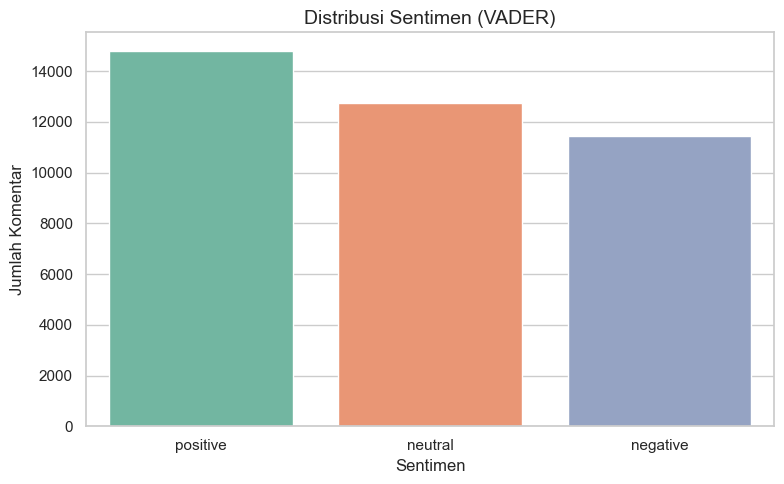

In [42]:
# Set style visual
sns.set(style="whitegrid")

# Bar chart
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='Set2')
plt.title('Distribusi Sentimen (VADER)', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Komentar')
plt.tight_layout()
plt.show()


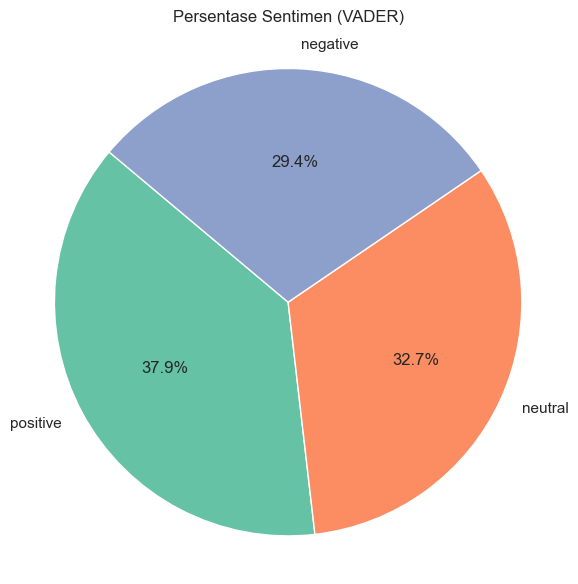

In [43]:
# Pie chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts['Count'], labels=sentiment_counts['Sentiment'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Persentase Sentimen (VADER)')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [44]:
# Fungsi buat WordCloud + Bar Chart Rank Kata
def generate_wordcloud_and_rank(df, sentiment_label, title):
    # Gabungkan semua teks berdasarkan sentimen
    text = " ".join(df[df['sentiment_vader'] == sentiment_label]['text_akhir'])

    # === WordCloud ===
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='Set2', max_words=200).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {title}", fontsize=16)
    plt.show()

    # === Rank Kata ===
    words = text.split()
    word_counts = Counter(words)
    ranked_words = word_counts.most_common(20)  # Top 20 kata

    # Pisahkan kata dan jumlahnya
    top_words, counts = zip(*ranked_words)

    # === Bar Chart ===
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(top_words), palette="viridis")
    plt.title(f"Top 20 Kata - {title}", fontsize=16)
    plt.xlabel('Jumlah Kemunculan')
    plt.ylabel('Kata')
    plt.tight_layout()
    plt.show()



### === Tampilkan WordCloud + Bar Chart Rank ===

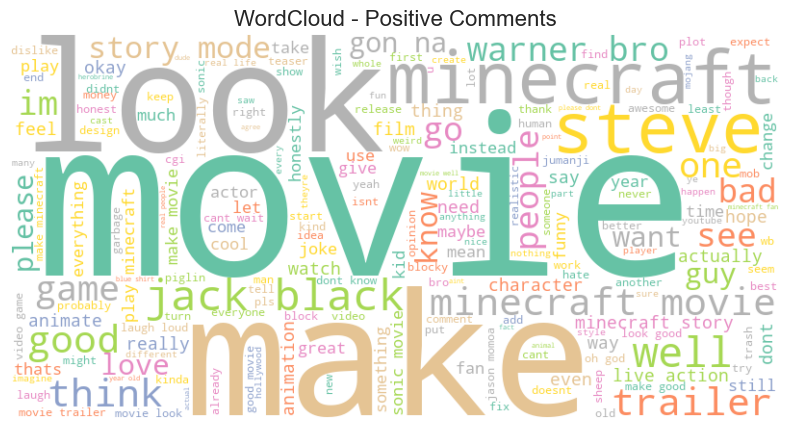

C:\Users\rizki\AppData\Local\Temp\ipykernel_30396\2239743764.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(top_words), palette="viridis")


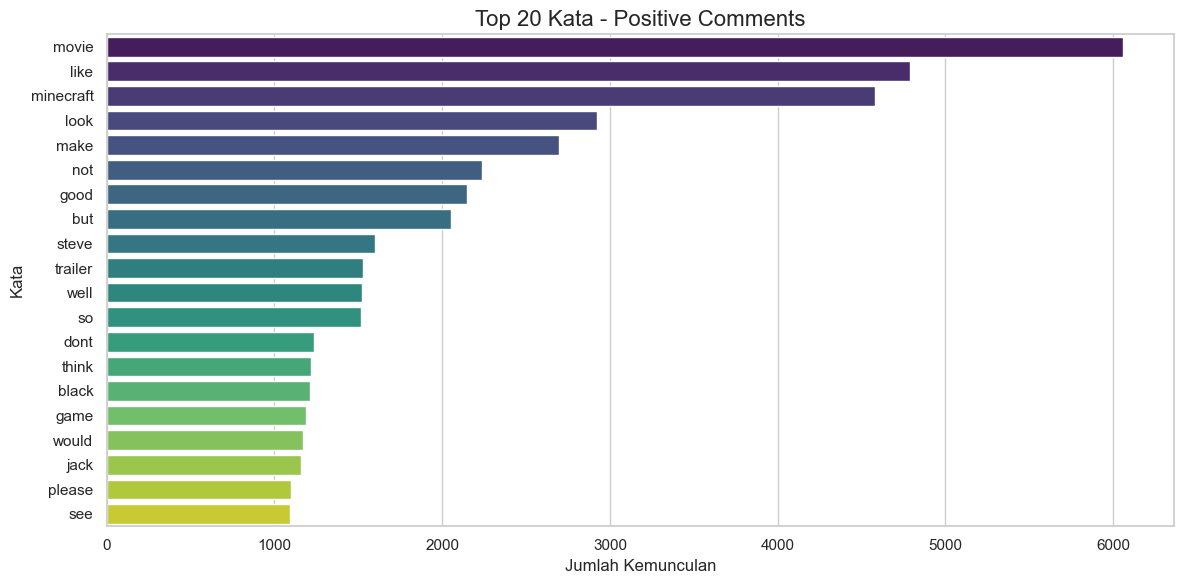

In [45]:
generate_wordcloud_and_rank(clean_df, 'positive', 'Positive Comments')


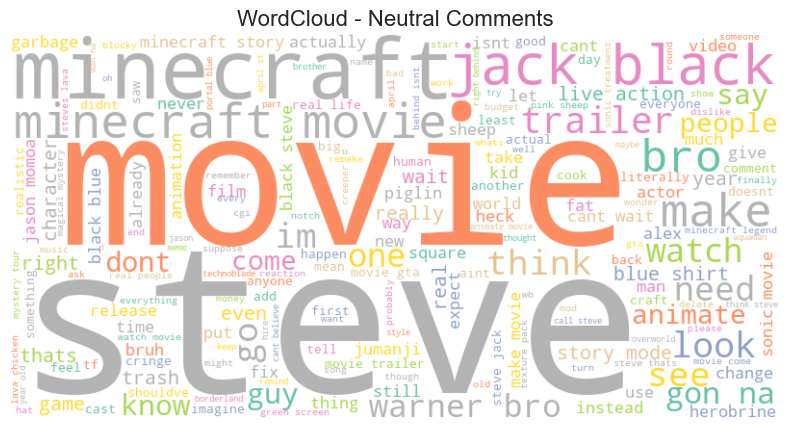

C:\Users\rizki\AppData\Local\Temp\ipykernel_30396\2239743764.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(top_words), palette="viridis")


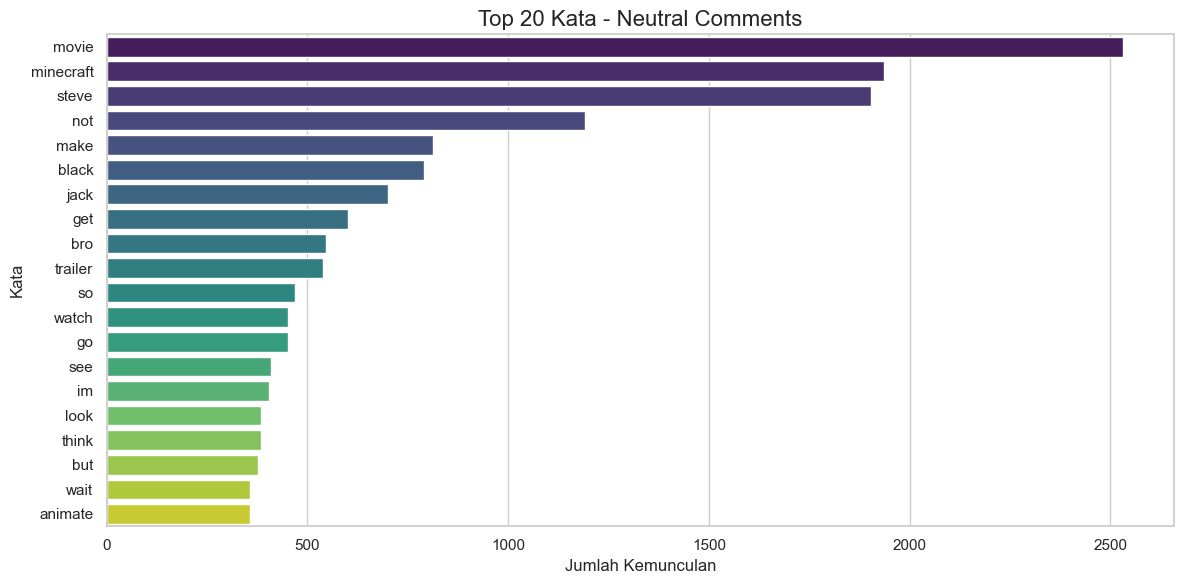

In [46]:
generate_wordcloud_and_rank(clean_df, 'neutral', 'Neutral Comments')


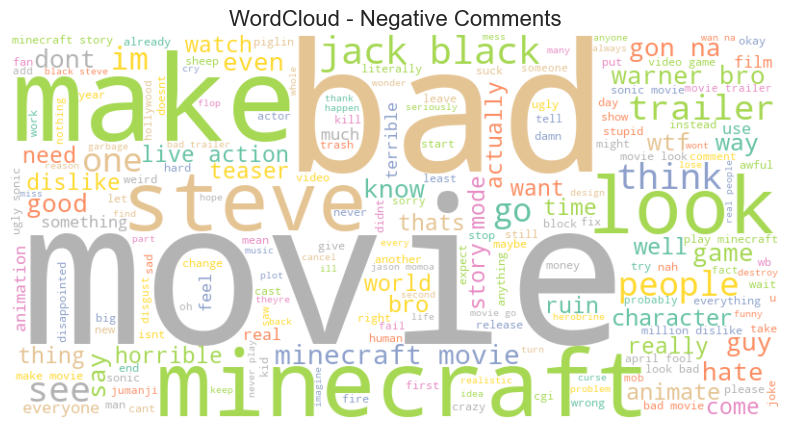

C:\Users\rizki\AppData\Local\Temp\ipykernel_30396\2239743764.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(top_words), palette="viridis")


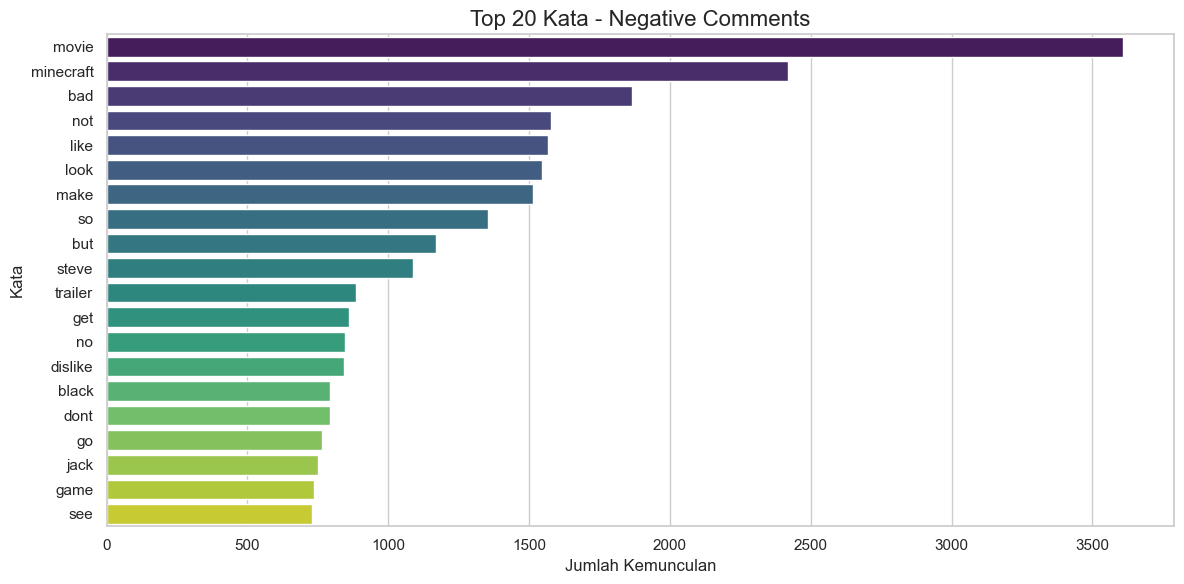

In [47]:
generate_wordcloud_and_rank(clean_df, 'negative', 'Negative Comments')

##TRAINING DATA DENGAN LSTM+CNN

In [48]:
# Encode labels

label_encoder = LabelEncoder()
clean_df['label'] = label_encoder.fit_transform(clean_df['sentiment_vader'])
num_classes = len(label_encoder.classes_)  # Number of unique classes (positive, neutral, negative)

###Data Augmentation

In [49]:
# Fungsi untuk mendapatkan sinonim
def get_synonym(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return random.choice(synonyms) if synonyms else word

In [50]:
# Fungsi augmentasi sinonim
def synonym_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        if len(words) > 1:
            insert_pos = random.randint(0, len(words) - 1)
            random_word = words[random.randint(0, len(words) - 1)]
            synonym = get_synonym(random_word)
            words.insert(insert_pos, synonym)
    return ' '.join(words)

In [51]:
# Fungsi penghapusan aman
def safe_deletion(text, p=0.2):
    words = text.split()
    if len(words) <= 1:
        return text
    stop_words = {'is', 'the', 'a', 'an', 'and', 'or', 'but'}
    new_words = []
    for word in words:
        if word.lower() in stop_words or random.random() > p:
            new_words.append(word)
    if not new_words:
        return words[0]
    return ' '.join(new_words)

In [52]:
# Fungsi validasi sentimen
def validate_sentiment(text, original_label):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if original_label == 0:  # Negatif
        return compound_score <= -0.05
    elif original_label == 1:  # Positif
        return compound_score >= 0.05
    else:  # Netral
        return -0.05 < compound_score < 0.05

In [53]:
# Fungsi augmentasi teks
def augment_text_improved(text):
    text = synonym_insertion(text, n=1)
    text = safe_deletion(text, p=0.2)
    return text

In [54]:
def augment_data_until_balanced(df, max_augmentation_factor=5):
    label_counts = df['label'].value_counts()
    max_count = label_counts.max()

    # Salin dataframe awal
    final_df = df.copy()

    print("Before augmentation:", label_counts.to_dict())

    while True:
        updated = False  # Penanda apakah ada augmentasi yang dilakukan
        label_counts = final_df['label'].value_counts()
        max_count = label_counts.max()

        for label, count in label_counts.items():
            if count < max_count:
                need = max_count - count
                augment_df = final_df[final_df['label'] == label].sample(frac=1).reset_index(drop=True)

                augmented_texts = []
                augmented_labels = []
                generated = 0

                for text in augment_df['text_akhir']:
                    if generated >= need:
                        break
                    augmented_text = augment_text_improved(text)
                    if validate_sentiment(augmented_text, label):
                        augmented_texts.append(augmented_text)
                        augmented_labels.append(label)
                        generated += 1
                        updated = True

                if augmented_texts:
                    temp_df = pd.DataFrame({'text_akhir': augmented_texts, 'label': augmented_labels})
                    final_df = pd.concat([final_df, temp_df], ignore_index=True)

        # Jika tidak ada augmentasi yang berhasil ditambahkan, hentikan loop
        if not updated:
            print("Augmentation stopped: No further valid augmentations could be created.")
            break

        # Cek apakah semua label sudah seimbang
        label_counts = final_df['label'].value_counts()
        if label_counts.min() >= label_counts.max():
            break

    print("[✓] Data augmentation completed!")
    print("After augmentation:", final_df['label'].value_counts().to_dict())

    return final_df


###TOKENIZATION AND PADDING

In [55]:
def prepare_data_with_class_weights(df, max_words=5000, max_length=100, num_classes=3):
    # Tokenisasi dan padding
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(df['text_akhir'])
    sequences = tokenizer.texts_to_sequences(df['text_akhir'])
    X_padded = pad_sequences(sequences, maxlen=max_length)

    # One-hot encoding untuk label
    y_encoded = to_categorical(df['label'], num_classes=num_classes)

    # Hitung class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
    class_weight_dict = dict(enumerate(class_weights))

    print("[✓] Data preparation and class weights computation completed!")
    print("Shape of X_padded:", X_padded.shape)
    print("Shape of y_encoded:", y_encoded.shape)
    print("Class weights:", class_weight_dict)

    return X_padded, y_encoded, tokenizer, class_weight_dict

In [56]:
def full_pipeline_with_class_weights(df, max_words=5000, max_length=100, num_classes=3):
    # Langkah 1: Gunakan DataFrame yang sudah dipreproses
    clean_df = df  # Langsung gunakan df yang diberikan (sudah memiliki text_akhir dan label)

    # Langkah 2: Augmentasi hingga balanced
    augmented_df = augment_data_until_balanced(clean_df)

    # Langkah 3: Tokenisasi, padding, one-hot encoding, dan class weights
    X_padded, y_encoded, tokenizer, class_weight_dict = prepare_data_with_class_weights(
        augmented_df, max_words, max_length, num_classes
    )

    return X_padded, y_encoded, tokenizer, class_weight_dict, augmented_df

In [57]:
# === Pipeline dan Pelatihan ===
X_padded, y_encoded, tokenizer, class_weight_dict, final_df = full_pipeline_with_class_weights(
    clean_df[['text_akhir', 'label']],
    max_words=5000,
    max_length=100,
    num_classes=3
)

# Encoder label for classification reports
label_encoder = LabelEncoder()
label_encoder.fit([0, 1, 2])
label_encoder.classes_ = np.array(['negative', 'positive', 'neutral'])

Before augmentation: {2: 14794, 1: 12749, 0: 11449}
[✓] Data augmentation completed!
After augmentation: {2: 14794, 1: 14794, 0: 14794}
[✓] Data preparation and class weights computation completed!
Shape of X_padded: (44382, 100)
Shape of y_encoded: (44382, 3)
Class weights: {0: 1.0, 1: 1.0, 2: 1.0}


###CUSTOM EARLY STOPPING CALLBACK

In [58]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.89, patience=5, monitor_train_acc=True):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy
        self.patience = patience
        self.monitor_train_acc = monitor_train_acc
        self.best_val_acc = 0.0
        self.wait = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy', 0.0)
        val_acc = logs.get('val_accuracy', 0.0)

        # Check if target accuracy is reached
        if val_acc >= self.target_accuracy and (not self.monitor_train_acc or train_acc >= self.target_accuracy):
            print(f"\n[✓] Early stopping at epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
            self.model.stop_training = True

        # Save best validation accuracy
        elif val_acc > self.best_val_acc:
            self.best_val_acc = val_acc
            self.wait = 0
            self.best_weights = self.model.get_weights()
            print(f"\n[✓] New best val_acc={val_acc:.4f} at epoch {epoch+1}, saving weights")

        # Stop if no improvement
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\n[✓] No improvement in val_acc for {self.patience} epochs. Stopping and restoring best weights.")
                self.model.stop_training = True
                self.model.set_weights(self.best_weights)

###Model

In [59]:
def build_lstm_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        
        # Increase dropout after embedding
        SpatialDropout1D(0.3),

        Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),

        Bidirectional(LSTM(16, return_sequences=False,
                           kernel_regularizer=tf.keras.regularizers.l2(0.02),
                           recurrent_dropout=0.4)),  # Reduced units and increased dropout

        Dropout(0.6),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [60]:
def train_evaluate_lstm_cnn(X, y, test_size, model_name,
                            class_weight_dict, label_encoder,
                            max_words, max_length, num_classes):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42,
        stratify=np.argmax(y, axis=1)
    )
    model = build_lstm_cnn_model(max_words, 100, max_length, num_classes)

    custom_early_stopping = CustomEarlyStopping(target_accuracy=0.89, patience=5, monitor_train_acc=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[custom_early_stopping, lr_scheduler],
        class_weight=class_weight_dict,
        verbose=1
    )

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    print(f"\n=== {model_name} Classification Report ===")
    print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Accuracy: {accuracy:.4f}")

    return accuracy, history, model, y_test_classes, y_pred_classes

In [61]:
# def build_lstm_cnn_model(vocab_size, embedding_dim, max_length, num_classes):
#     model = Sequential([
#         Embedding(vocab_size, embedding_dim, input_length=max_length),
#         SpatialDropout1D(0.2),

#         Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
#         BatchNormalization(),
#         MaxPooling1D(pool_size=2),
#         Dropout(0.3),

#         Bidirectional(LSTM(
#             64,
#             return_sequences=False,
#             dropout=0.2,
#             recurrent_dropout=0.2
#         )),

#         Dense(64, activation='relu'),
#         Dropout(0.3),

#         Dense(num_classes, activation='softmax')
#     ])

#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

In [62]:
# def train_evaluate_lstm_cnn(X, y, test_size, model_name,
#                             class_weight_dict, label_encoder,
#                             max_words, max_length, num_classes):

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=42,
#         stratify=np.argmax(y, axis=1)
#     )

#     model = build_lstm_cnn_model(max_words, 100, max_length, num_classes)

#     custom_early_stopping = CustomEarlyStopping(
#         target_accuracy=0.89,
#         patience=5,
#         monitor_train_acc=True
#     )

#     lr_scheduler = ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=3,
#         min_lr=1e-6,
#         verbose=1
#     )

#     history = model.fit(
#         X_train, y_train,
#         epochs=30,
#         batch_size=32,
#         validation_split=0.2,
#         callbacks=[custom_early_stopping, lr_scheduler],
#         class_weight=class_weight_dict,
#         verbose=1
#     )

#     y_pred = model.predict(X_test)
#     y_pred_classes = np.argmax(y_pred, axis=1)
#     y_test_classes = np.argmax(y_test, axis=1)

#     print(f"\n=== {model_name} Classification Report ===")
#     print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))
#     accuracy = accuracy_score(y_test_classes, y_pred_classes)
#     print(f"Accuracy: {accuracy:.4f}")

#     return accuracy, history, model, y_test_classes, y_pred_classes


In [63]:
# === Training with 80/20 and 70/30 Splits ===
print("\n=== LSTM+CNN with 80/20 Split ===")
acc_80_20, history_80_20, model_80_20, y_test_80_20, y_pred_80_20 = train_evaluate_lstm_cnn(
    X_padded, y_encoded, test_size=0.2,
    model_name="LSTM+CNN 80/20",
    class_weight_dict=class_weight_dict,
    label_encoder=label_encoder,
    max_words=5000,
    max_length=100,
    num_classes=3
)


=== LSTM+CNN with 80/20 Split ===
Epoch 1/30


c:\Users\rizki\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


887/888 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3435 - loss: 4.2089
[✓] New best val_acc=0.3887 at epoch 1, saving weights
888/888 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.3436 - loss: 4.2084 - val_accuracy: 0.3887 - val_loss: 3.2302 - learning_rate: 1.0000e-04
Epoch 2/30
887/888 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3639 - loss: 3.3784
[✓] New best val_acc=0.4263 at epoch 2, saving weights
888/888 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.3639 - loss: 3.3781 - val_accuracy: 0.4263 - val_loss: 2.7199 - learning_rate: 1.0000e-04
Epoch 3/30
887/888 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3724 - loss: 2.8538
[✓] New best val_acc=0.4349 at epoch 3, saving weights
888/888 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.3724 - loss: 2.8536 - val_accuracy: 0.4349 - val_loss: 2.3623 - learning_rate: 1.0000e-04
Epoch 4/30
887/888 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3824 - loss: 2.4372
[✓] New best val_acc=0.4819 at epoch 4, saving weights
88

In [64]:
print("\n=== LSTM+CNN with 70/30 Split ===")
acc_70_30, history_70_30, model_70_30, y_test_70_30, y_pred_70_30 = train_evaluate_lstm_cnn(
    X_padded, y_encoded, test_size=0.3,
    model_name="LSTM+CNN 70/30",
    class_weight_dict=class_weight_dict,
    label_encoder=label_encoder,
    max_words=5000,
    max_length=100,
    num_classes=3
)


=== LSTM+CNN with 70/30 Split ===
Epoch 1/30


c:\Users\rizki\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


776/777 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3432 - loss: 4.1523
[✓] New best val_acc=0.3346 at epoch 1, saving weights
777/777 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.3432 - loss: 4.1518 - val_accuracy: 0.3346 - val_loss: 3.3071 - learning_rate: 1.0000e-04
Epoch 2/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.3540 - loss: 3.4194 - val_accuracy: 0.3346 - val_loss: 2.8533 - learning_rate: 1.0000e-04
Epoch 3/30
776/777 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3625 - loss: 2.9049
[✓] New best val_acc=0.3452 at epoch 3, saving weights
777/777 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.3625 - loss: 2.9047 - val_accuracy: 0.3452 - val_loss: 2.4793 - learning_rate: 1.0000e-04
Epoch 4/30
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3773 - loss: 2.5136
[✓] New best val_acc=0.3584 at epoch 4, saving weights
777/777 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.3773 - loss: 2.5135 - val_accuracy: 0.3584 - val_loss: 2.1773 - learning_rat

##Evaluation

In [65]:
# === COMPARISON OF RESULTS ===
results = pd.DataFrame({
    'Model': ['LSTM+CNN 80/20', 'LSTM+CNN 70/30'],
    'Accuracy': [acc_80_20, acc_70_30]  # Use correct variable names
})

print("\n=== Comparison of Model Performance ===")
print(results)


=== Comparison of Model Performance ===
            Model  Accuracy
0  LSTM+CNN 80/20  0.858060
1  LSTM+CNN 70/30  0.856252


C:\Users\rizki\AppData\Local\Temp\ipykernel_30396\1238302750.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='Set2')


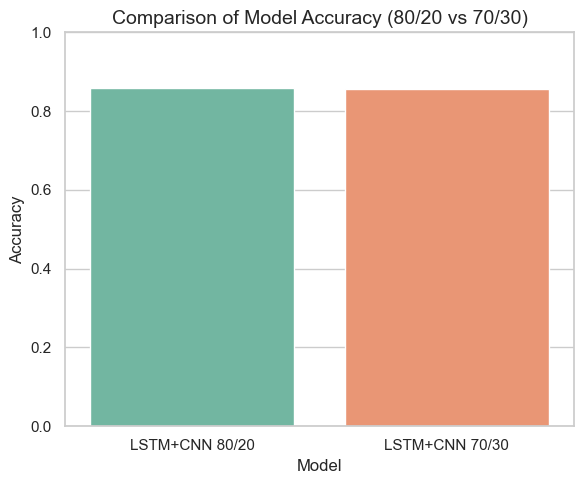

In [66]:
# === BAR CHART: Accuracy Comparison ===
plt.figure(figsize=(6, 5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='Set2')
plt.title('Comparison of Model Accuracy (80/20 vs 70/30)', fontsize=14)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig('01_model_accuracy_comparison.png')
plt.show()

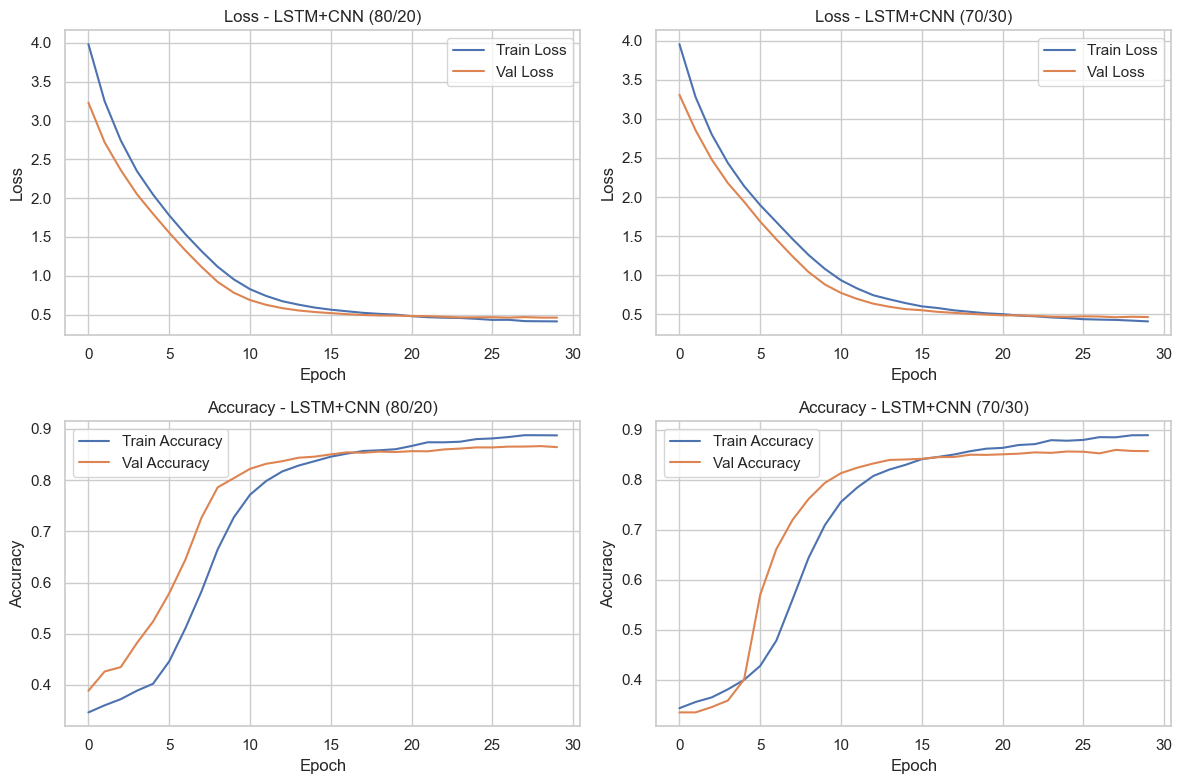

In [86]:
# === LOSS & ACCURACY VISUALIZATION ===
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 80/20 - Loss
axs[0, 0].plot(history_80_20.history['loss'], label='Train Loss')
axs[0, 0].plot(history_80_20.history['val_loss'], label='Val Loss')
axs[0, 0].set_title('Loss - LSTM+CNN (80/20)')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# 80/20 - Accuracy
axs[1, 0].plot(history_80_20.history['accuracy'], label='Train Accuracy')
axs[1, 0].plot(history_80_20.history['val_accuracy'], label='Val Accuracy')
axs[1, 0].set_title('Accuracy - LSTM+CNN (80/20)')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

# 70/30 - Loss
axs[0, 1].plot(history_70_30.history['loss'], label='Train Loss')
axs[0, 1].plot(history_70_30.history['val_loss'], label='Val Loss')
axs[0, 1].set_title('Loss - LSTM+CNN (70/30)')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# 70/30 - Accuracy
axs[1, 1].plot(history_70_30.history['accuracy'], label='Train Accuracy')
axs[1, 1].plot(history_70_30.history['val_accuracy'], label='Val Accuracy')
axs[1, 1].set_title('Accuracy - LSTM+CNN (70/30)')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [68]:
class_names = ['negative', 'positive', 'neutral']


def plot_confusion_and_class_metrics(y_true, y_pred, class_names, title_suffix=""):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    plt.figure(figsize=(6, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.show()

    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1, 2])
    scores_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    scores_df.set_index('Class').plot(kind='bar', figsize=(8, 5), ylim=(0, 1), colormap='viridis')
    plt.title(f"Performa Tiap Kelas {title_suffix}")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


<Figure size 600x600 with 0 Axes>

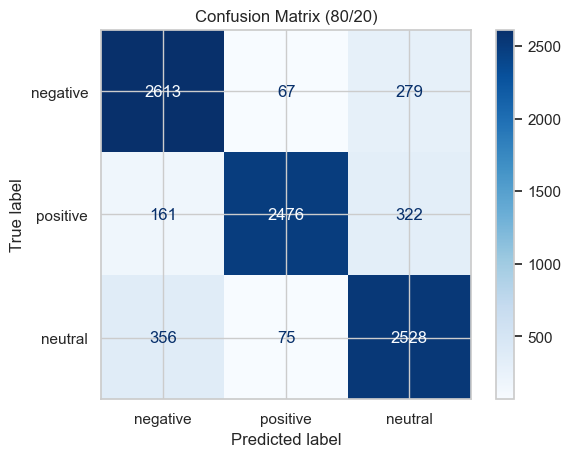

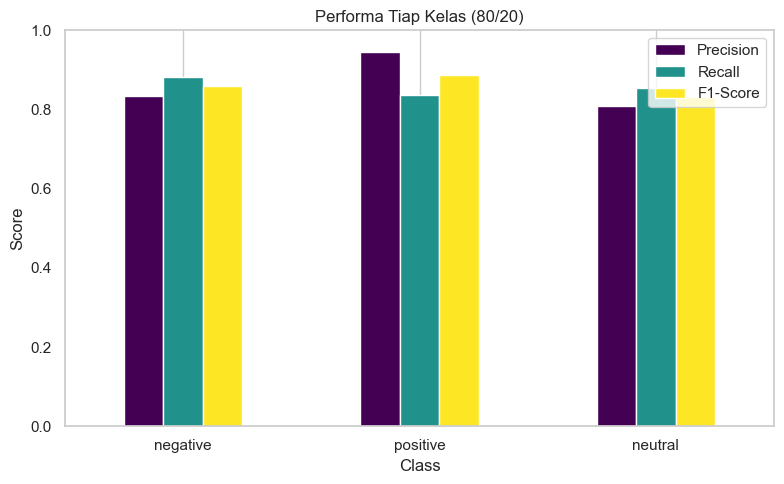

In [69]:
plot_confusion_and_class_metrics(y_test_80_20, y_pred_80_20, class_names, title_suffix="(80/20)")

<Figure size 600x600 with 0 Axes>

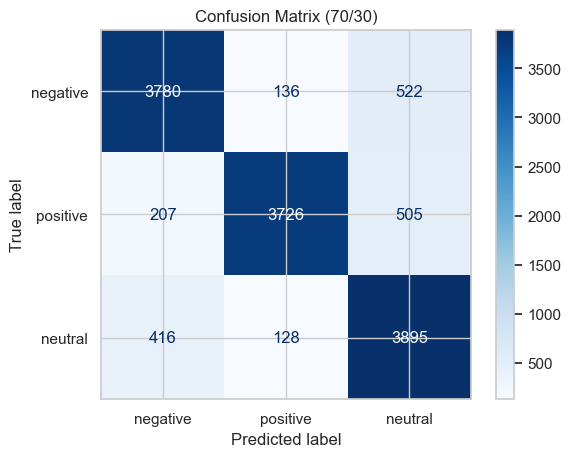

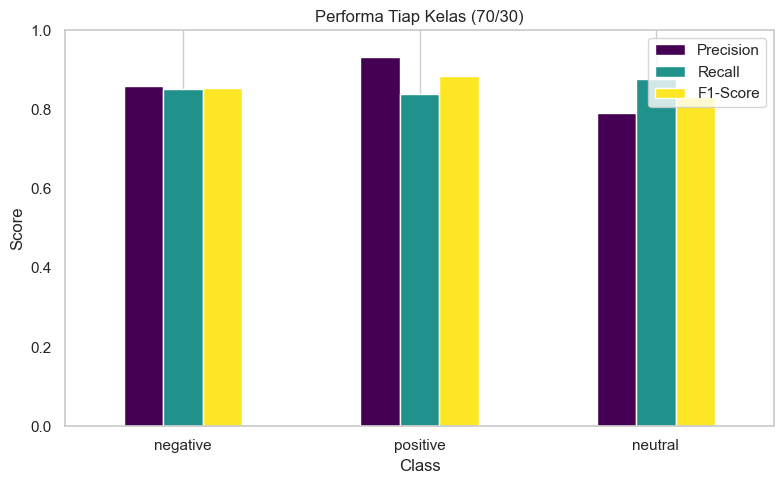

In [70]:
plot_confusion_and_class_metrics(y_test_70_30, y_pred_70_30, class_names, title_suffix="(70/30)")

##SaveModel dan Deployment


In [71]:
# === Selecting the Best Model ===
print("\n=== Selecting the Best Model ===")
print(f"LSTM+CNN 80/20 Accuracy: {acc_80_20:.4f}")
print(f"LSTM+CNN 70/30 Accuracy: {acc_70_30:.4f}")


=== Selecting the Best Model ===
LSTM+CNN 80/20 Accuracy: 0.8581
LSTM+CNN 70/30 Accuracy: 0.8563


In [72]:
# Tentukan model terbaik berdasarkan akurasi
if acc_80_20 >= acc_70_30:
    best_split = "80/20"
    best_accuracy = acc_80_20
    best_model = model_80_20
else:
    best_split = "70/30"
    best_accuracy = acc_70_30
    best_model = model_70_30

print(f"[✓] Selected model: {best_split} with accuracy: {best_accuracy:.4f}")

[✓] Selected model: 80/20 with accuracy: 0.8581


In [73]:
# === Save the Best Model ===
model_filename = f"lstm_cnn_sentiment_model_{best_split.replace('/', '_')}.h5"
best_model.save(model_filename, include_optimizer=True)
print(f"[✓] Best model saved as '{model_filename}'")

[✓] Best model saved as 'lstm_cnn_sentiment_model_80_20.h5'


In [74]:
# === Save the Tokenizer ===
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"[✓] Tokenizer saved as '{tokenizer_filename}'")

[✓] Tokenizer saved as 'tokenizer.pkl'


In [75]:
# === Save the Label Encoder ===
label_encoder_filename = 'label_encoder.pkl'
with open(label_encoder_filename, 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"[✓] Label encoder saved as '{label_encoder_filename}'")

[✓] Label encoder saved as 'label_encoder.pkl'


In [78]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import string

# Download NLTK resources (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

# Define custom stopwords
important_stopwords = {
    "not", "no", "nor", "never", "none", "nobody", "nothing", "neither",
    "n't", "don't", "didn't", "doesn't", "won't", "wouldn't", "can't",
    "cannot", "couldn't", "shouldn't", "mustn't", "isn't", "aren't", "wasn't", "weren't",
    "haven't", "hasn't", "hadn't", "without", "barely", "hardly", "scarcely",
    "very", "extremely", "really", "so", "too", "quite",
    "but", "although", "however", "yet"
}
custom_stop_words = stop_words - important_stopwords

# Slang dictionary
slang_dict = {
    "u": "you", "r": "are", "ur": "your", "btw": "by the way", "idk": "i do not know",
    "lol": "laughing out loud", "omg": "oh my god", "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing", "brb": "be right back", "gtg": "got to go",
    "imo": "in my opinion", "imho": "in my humble opinion", "fyi": "for your information",
    "tbh": "to be honest", "smh": "shaking my head", "np": "no problem", "jk": "just kidding",
    "nvm": "never mind", "bff": "best friend forever", "dm": "direct message",
    "tldr": "too long did not read", "wth": "what the heck", "ikr": "i know right",
    "ya": "yeah", "thx": "thanks", "ty": "thank you", "plz": "please", "bc": "because",
    "cuz": "because", "tho": "though", "k": "okay", "ok": "okay", "hbu": "how about you",
    "wyd": "what are you doing", "wbu": "what about you", "rn": "right now", "bday": "birthday",
    "gr8": "great", "luv": "love", "xoxo": "hugs and kisses", "yall": "you all",
    "sick": "awesome", "dope": "cool", "lit": "amazing", "fam": "friends",
    "salty": "upset", "shade": "disrespect", "tea": "gossip", "yolo": "you only live once",
    "fomo": "fear of missing out", "vibes": "feelings", "im" :"i am"
}

# Load model and tools
model = load_model("lstm_cnn_sentiment_model_80_20.h5")

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# === Fungsi preprocessing ===
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def cleaningText(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

def casefoldingText(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def validate_slang_standardization(original_text, standardized_text):
    original_score = analyzer.polarity_scores(original_text)['compound']
    standardized_score = analyzer.polarity_scores(standardized_text)['compound']
    return abs(original_score - standardized_score) < 0.3

def standard_slangwords(text):
    tokens = word_tokenize(text)
    standardized_tokens = [slang_dict.get(token.lower(), token) for token in tokens]
    standardized_text = " ".join(standardized_tokens)
    if validate_slang_standardization(text, standardized_text):
        return standardized_text
    return text

def tokenizingText(text):
    return word_tokenize(text)

def validate_stopword_removal(original_text, filtered_tokens):
    filtered_text = ' '.join(filtered_tokens)
    original_scores = analyzer.polarity_scores(original_text)
    filtered_scores = analyzer.polarity_scores(filtered_text)
    return abs(original_scores['compound'] - filtered_scores['compound']) < 0.3

def filteringText(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in custom_stop_words]
    if validate_stopword_removal(' '.join(tokens), filtered_tokens):
        return filtered_tokens
    return tokens

def validate_sentiment(original_text, processed_text):
    original_scores = analyzer.polarity_scores(original_text)
    processed_scores = analyzer.polarity_scores(processed_text)
    return abs(original_scores['compound'] - processed_scores['compound']) < 0.3

def lemmatizationText(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]
    if validate_sentiment(' '.join(tokens), ' '.join(lemmatized_tokens)):
        return lemmatized_tokens
    return tokens

def preprocess_text_for_inference(text):
    text = cleaningText(text)
    text = casefoldingText(text)
    text = standard_slangwords(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    tokens = lemmatizationText(tokens)
    return ' '.join(tokens)

# === Fungsi VADER Sentiment Analysis ===
def vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# === Fungsi prediksi sentimen ===
def predict_sentiment(text, model, tokenizer, label_encoder, max_length=100):
    preprocessed_text = preprocess_text_for_inference(text)

    # Analisis VADER
    vader_original_score = analyzer.polarity_scores(text)['compound']
    vader_processed_score = analyzer.polarity_scores(preprocessed_text)['compound']
    vader_original_label = vader_sentiment(text)
    vader_processed_label = vader_sentiment(preprocessed_text)

    # Prediksi model
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded = pad_sequences(sequence, maxlen=max_length)
    prediction = model.predict(padded, verbose=0)
    predicted_label = np.argmax(prediction, axis=1)[0]
    sentiment = label_encoder.inverse_transform([predicted_label])[0]
    confidence = np.max(prediction)

    # === Hasil ===
    print("\n=== HASIL PREDIKSI MODEL ===")
    print(f"Teks asli                 : {text}")
    print(f"Teks setelah preprocessing: {preprocessed_text}")
    print(f"Prediksi Sentimen Model   : {sentiment}")
    print(f"Akurasi Confidence        : {confidence:.4f}")

    print("\n=== ANALISIS VADER ===")
    print(f"VADER - Compound (Asli)     : {vader_original_score:.4f}  -> {vader_original_label}")
    print(f"VADER - Compound (Prepro)   : {vader_processed_score:.4f}  -> {vader_processed_label}")

    return sentiment

# === Interaktif: input dari pengguna ===
while True:
    user_input = input("\nMasukkan teks ulasan (atau ketik 'exit' untuk keluar): ")
    if user_input.lower() == 'exit':
        print("Terima kasih! Keluar dari program.")
        break
    predict_sentiment(user_input, model, tokenizer, label_encoder)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rizki\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-


=== HASIL PREDIKSI MODEL ===
Teks asli                 : I was on the edge of my seat the whole time, so thrilling!
Teks setelah preprocessing: edge seat whole time so thrill
Prediksi Sentimen Model   : positive
Akurasi Confidence        : 0.6658

=== ANALISIS VADER ===
VADER - Compound (Asli)     : 0.6466  -> positive
VADER - Compound (Prepro)   : 0.5009  -> positive

=== HASIL PREDIKSI MODEL ===
Teks asli                 : This movie is a masterpiece, I loved every minute of it!
Teks setelah preprocessing: movie masterpiece love every minute
Prediksi Sentimen Model   : neutral
Akurasi Confidence        : 0.9782

=== ANALISIS VADER ===
VADER - Compound (Asli)     : 0.8516  -> positive
VADER - Compound (Prepro)   : 0.8519  -> positive

=== HASIL PREDIKSI MODEL ===
Teks asli                 : The film was incredible, the acting was superb!
Teks setelah preprocessing: film incredible act superb
Prediksi Sentimen Model   : positive
Akurasi Confidence        : 0.9981

=== ANALISIS VADER =